In [ ]:
import pandas as pd
import numpy as np

# 1. Leitura dos Dados
file_path = 'sth617.919_637.919.xlsx'  # Substitua pelo caminho correto do arquivo
df = pd.read_excel(file_path, usecols=['km', 'D0'])

# 2. Cálculo de Dm
df['Dm'] = (df['D0'].shift(1) + df['D0']) / 2

# 3. Cálculo de Delta Li
df['Delta Li'] = (df['km'].diff())*1000

# 4. Cálculo de Soma Delta Li
df['Soma Delta Li'] = df['Delta Li'].cumsum()

# 5. Cálculo de Ai
df['Ai'] = df['Delta Li'] * df['Dm']

# 6. Cálculo de Soma Ai
df['Soma Ai'] = df['Ai'].cumsum()

# 7. Cálculo de tg alpha
tg_alpha = df['Ai'].sum() / df['Delta Li'].sum()
df['tg alpha'] = tg_alpha

# 8. Cálculo de Zi
df['Zi'] = df['Soma Ai'] - (df['Soma Delta Li'] * tg_alpha)

# Substituindo os NaN por 0
df.fillna(0, inplace=True)

# 9. Cálculo de Slope
df['Slope'] = df['Zi'].shift(-1) - df['Zi']

# 10. Cálculo de Segment
df['Segment'] = 1  # Inicialização da coluna Segment
for i in range(2, len(df)):
    # Verifica se o sinal de Slope é o mesmo entre as linhas consecutivas
    if np.sign(df.at[i, 'Slope']) == np.sign(df.at[i-1, 'Slope']):
        df.at[i, 'Segment'] = df.at[i-1, 'Segment']
    else:
        df.at[i, 'Segment'] = df.at[i-1, 'Segment'] + 1

# Exibindo os resultados
print(df)

          km    D0     Dm  Delta Li  Soma Delta Li      Ai    Soma Ai  \
0    617.919  51.9   0.00       0.0            0.0     0.0       0.00   
1    618.019  23.9  37.90     100.0          100.0  3790.0    3790.00   
2    618.119  27.6  25.75     100.0          200.0  2575.0    6365.00   
3    618.218  14.8  21.20      99.0          299.0  2098.8    8463.80   
4    618.318  23.5  19.15     100.0          399.0  1915.0   10378.80   
..       ...   ...    ...       ...            ...     ...        ...   
197  637.494  32.4  32.40     100.0        19575.0  3240.0  644624.75   
198  637.594  41.9  37.15     100.0        19675.0  3715.0  648339.75   
199  637.693  46.1  44.00      99.0        19774.0  4356.0  652695.75   
200  637.793  34.2  40.15     100.0        19874.0  4015.0  656710.75   
201  637.893  30.2  32.20     100.0        19974.0  3220.0  659930.75   

      tg alpha            Zi        Slope  Segment  
0    33.039489  0.000000e+00   486.051116        1  
1    33.039489  4

In [ ]:
# Salvar os resultados de MDA
df.to_excel('resultado MDA 617.xlsx', index=False)

In [ ]:
import pandas as pd

# Carregar a planilha de resultados
file_path = 'resultado MDA 617.xlsx'
df = pd.read_excel(file_path)

# Identificar segmentos de linha única
unique_segments = df['Segment'].value_counts() == 1
single_line_segments = unique_segments[unique_segments].index

# Inicializar a nova coluna 'Real Segments' com os valores atuais da coluna 'Segment'
df['Real Segments'] = df['Segment']

# Processamento dos segmentos de linha única
for seg in single_line_segments:
    # Encontrar índices dos segmentos de linha única
    single_line_index = df[df['Segment'] == seg].index[0]

    # Identificar os segmentos vizinhos
    previous_segment = df.at[single_line_index - 1, 'Segment'] if single_line_index > 0 else None
    next_segment = df.at[single_line_index + 1, 'Segment'] if single_line_index < len(df) - 1 else None

    # Calcular a média de D0 para os segmentos vizinhos
    previous_segment_mean = df[df['Segment'] == previous_segment]['D0'].mean() if previous_segment else float('-inf')
    next_segment_mean = df[df['Segment'] == next_segment]['D0'].mean() if next_segment else float('-inf')

    # Decidir a qual segmento adicionar o segmento de linha única
    if previous_segment_mean > next_segment_mean:
        df.at[single_line_index, 'Real Segments'] = previous_segment
    else:
        df.at[single_line_index, 'Real Segments'] = next_segment

# Reordenar os segmentos para que sejam sequenciais
df['Real Segments'] = pd.factorize(df['Real Segments'])[0] + 1

# Salvando o DataFrame alterado
output_file_path = 'MDA real segments 617.xlsx'
df.to_excel(output_file_path, index=False)

output_file_path



'MDA real segments 617.xlsx'

In [ ]:
# Carregando o DataFrame atualizado
df = pd.read_excel('MDA real segments 617.xlsx')

# Identificando novamente segmentos de linha única
unique_segments = df['Real Segments'].value_counts() == 1
single_line_segments = unique_segments[unique_segments].index

# Processamento adicional dos segmentos de linha única
for seg in single_line_segments:
    # Encontrar índices dos segmentos de linha única
    single_line_index = df[df['Real Segments'] == seg].index[0]

    # Identificar os segmentos vizinhos
    previous_segment = df.at[single_line_index - 1, 'Real Segments'] if single_line_index > 0 else None
    next_segment = df.at[single_line_index + 1, 'Real Segments'] if single_line_index < len(df) - 1 else None

    # Se houver apenas um segmento vizinho, atribuir o segmento de linha única a este vizinho
    if previous_segment is None:
        df.at[single_line_index, 'Real Segments'] = next_segment
    elif next_segment is None:
        df.at[single_line_index, 'Real Segments'] = previous_segment
    else:
        # Calcular a média de D0 para os segmentos vizinhos
        previous_segment_mean = df[df['Real Segments'] == previous_segment]['D0'].mean()
        next_segment_mean = df[df['Real Segments'] == next_segment]['D0'].mean()

        # Decidir a qual segmento adicionar o segmento de linha única
        if previous_segment_mean > next_segment_mean:
            df.at[single_line_index, 'Real Segments'] = previous_segment
        else:
            df.at[single_line_index, 'Real Segments'] = next_segment

# Reordenar os segmentos para que sejam sequenciais
df['Real Segments'] = pd.factorize(df['Real Segments'])[0] + 1

# Salvando o DataFrame novamente alterado
output_file_path = 'MDA real segments 617_2.xlsx'
df.to_excel(output_file_path, index=False)

output_file_path



'MDA real segments 617_2.xlsx'

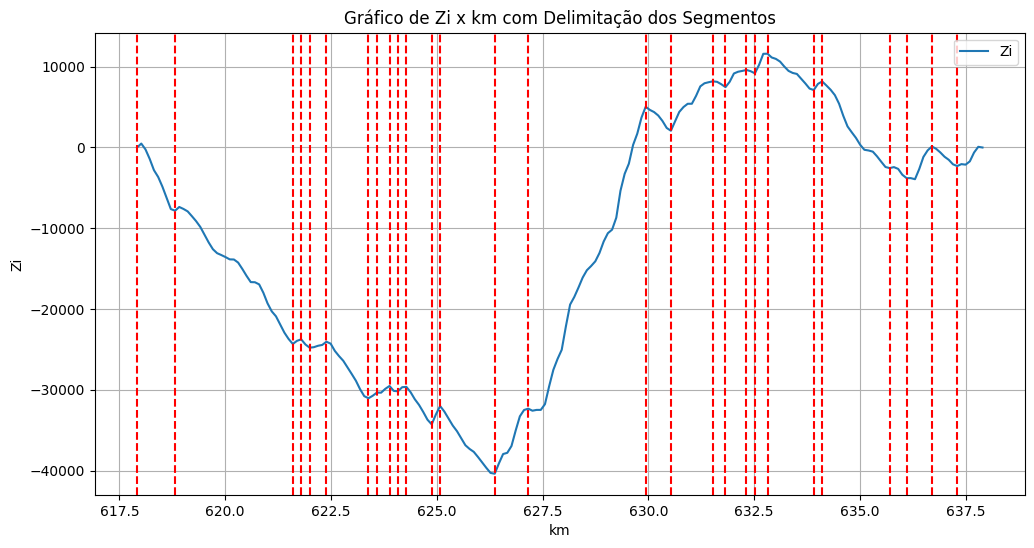

In [ ]:
import matplotlib.pyplot as plt

# Carregar o DataFrame atualizado
df = pd.read_excel('MDA real segments 617_2.xlsx')

# Plotar gráfico de linhas de Zi x km
plt.figure(figsize=(12, 6))
plt.plot(df['km'], df['Zi'], label='Zi')

# Adicionar linhas verticais para delimitar os segmentos
for segment in df['Real Segments'].unique():
    segment_indices = df[df['Real Segments'] == segment].index
    if len(segment_indices) > 0:
        km_value = df.at[segment_indices[0], 'km']
        plt.axvline(x=km_value, color='red', linestyle='--')

plt.xlabel('km')
plt.ylabel('Zi')
plt.title('Gráfico de Zi x km com Delimitação dos Segmentos')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# Carregando o arquivo fornecido
data_full = pd.read_excel("hdbscan_wf_450_mcs_2_xcs_10_ms_1_epsilon_0.18.xlsx")

# Adicionando a coluna de cluster ao final da planilha fornecida
data_full['Cluster'] = df['Real Segments']

# Calculando o coeficiente de variação para cada cluster
cluster_mean_full = data_full.groupby('Cluster').mean()
cluster_std_full = data_full.groupby('Cluster').std()

# Coeficiente de variação = (Desvio padrão / Média) * 100
cluster_cv_full = (cluster_std_full / cluster_mean_full) * 100

# Adicionando a contagem de linhas por cluster
cluster_cv_full['Number of Rows'] = data_full.groupby('Cluster').size()

# Reordenando as colunas
cols_full = cluster_cv_full.columns.tolist()
cols_full = [cols_full[-1]] + cols_full[:-1]
cluster_cv_full = cluster_cv_full[cols_full]

cluster_cv_full.reset_index(inplace=True)

cluster_cv_full.head()

,Cluster,Number of Rows,km,D0,D20,D30,D45,D60,D90,D120,IRI,Rut Depth,% Cracking,Other Distresses
0,1,9,0.151676,4.732663,3.764135,2.080923,4.228750,10.440578,18.426110,24.067929,39.980468,57.519643,70.800009,100.509928
1,2,28,0.449022,6.341694,2.592494,2.165448,7.085491,13.770238,19.877124,22.705237,47.505370,23.332922,102.284095,128.586085
2,3,2,0.038150,1.088834,0.541179,0.683529,0.259317,1.531383,4.699902,10.510792,56.298311,9.852506,13.468701,141.421356
3,4,2,0.038494,3.136733,2.980583,1.063734,2.441470,6.716765,13.966387,19.807204,20.064079,25.282195,12.856487,0.000000
4,5,4,0.069745,3.271346,0.884813,1.345909,3.439699,7.510879,11.285501,13.433944,42.386196,18.818728,36.514837,48.948710


In [ ]:
# Salvando a planilha com coeficiente de variação por cluster em um arquivo Excel
cv_output_full_path = "1.clusters cv.xlsx"
cluster_cv_full.to_excel(cv_output_full_path, index=False)

cv_output_full_path


'1.clusters cv.xlsx'

In [ ]:
# Carregando o arquivo fornecido
df = pd.read_excel("1.clusters cv.xlsx")

In [ ]:
# Calcular a média das colunas D, K, L e M
mean_d = df.iloc[:, 3].mean()  # Coluna D é a 4ª coluna, indexada como 3
mean_k = df.iloc[:, 10].mean() # Coluna K é a 11ª coluna, indexada como 10
mean_l = df.iloc[:, 11].mean() # Coluna L é a 12ª coluna, indexada como 11
mean_m = df.iloc[:, 12].mean() # Coluna M é a 13ª coluna, indexada como 12

# Exibir as médias
print("CV médio de D0:", mean_d)
print("CV médio de IRI:", mean_k)
print("CV médio de ATR:", mean_l)
print("CV médio de Trincamento:", mean_m)

CV médio de D0: 4.123879865747327
CV médio de IRI: 48.07256479003788
CV médio de ATR: 32.596117291572234
CV médio de Trincamento: 68.31814910055228
